
<span style="color:crimson;">**Context**

Users try to decide among alternatives when it comes to purchasing a product or service. At this point, there are factors that affect the purchasing behavior of the user. One of the most important of these is social proof, namely The wisdom of crowds (news, comments, youtube videos etc.). 

In the world of digital marketing, it is the user comments that enable the product to be purchased.

This dataset contains product reviews and metadata from Amazon for the product with the most comments in the electronics category.  

   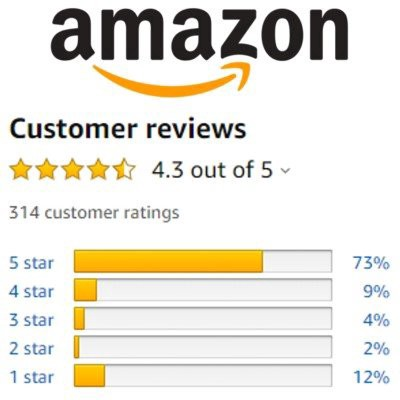
   

<span style="color:crimson;">**Business Problem**

This notebook provides more precise calculation of product ratings and ranking of product reviews that will be displayed on the product detail page.

<span style="color:crimson;">**Task Details**

* [1.Importing Libraries and Data](#section-one)
* [2.Rating Products](#section-two)
    * [2.1. Calculating Time-Based Weighted Average](#sub_section)
* [3.Sorting Reviews with Wilson Lower Bound Score](#section-three)

  
<span style="color:crimson;">**Attribute Information:**

* **reviewerID :** ID of the reviewer, e.g. A2SUAM1J3GNN3B
* **asin :** ID of the product, e.g. 0000013714
* **reviewerName :** name of the reviewer
* **helpful :** helpfulness rating of the review, e.g. 2/3
* **reviewText :** text of the review
* **overall :** rating of the product
* **summary :** summary of the review
* **unixReviewTime :** time of the review (unix time)
* **reviewTime :** time of the review (raw)
* **day_diff :** Number of days since evaluation
* **helpful_yes :** Number of times the review was found helpful
* **total_vote :** Number of votes given to the review

<a id="section-one"></a>
# <span style="color:crimson;"> 1. IMPORTING LIBRARIES AND DATA

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as st

pd.set_option ('display.max_columns', None)
pd.set_option ('display.width', 500)
pd.set_option ('display.expand_frame_repr', False)
pd.set_option ('display.float_format', lambda x: '%.5f' % x)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv("../input/amazon-reviews/amazon_reviews.csv")
df.head()

/kaggle/input/amazon-reviews/amazon_reviews.csv


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00000,best deal around,1373673600,2013-07-13,513,0,0


In [2]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1.00000,Do not waste your money.,1374537600,2013-07-23,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5.00000,Great item!,1377129600,2013-08-22,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.00000,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.00000,Great little card,1379289600,2013-09-16,448,0,0
4914,A8KGFTFQ86IBR,B007WTAJTO,Zza,"[0, 0]",I've heard bad things about this 64gb Micro SD...,5.00000,So far so good.,1388620800,2014-02-01,310,0,0


<a id="section-two"></a>
# <span style="color:crimson;">2.RATING PRODUCTS

In [3]:
df["overall"].mean()

4.587589013224822

Looking at the table above, I understand that ranking only by overall rating does not work for me, but the date of comment is also important.  

<a id="sub_section"></a>
## <span style="color:crimson;"> 2.1. Calculating Time-Based Weighted Average

The date_diff variable shows how current the comment is. 

In [4]:
df['day_diff'].describe()

count   4915.00000
mean     437.36704
std      209.43987
min        1.00000
25%      281.00000
50%      431.00000
75%      601.00000
max     1064.00000
Name: day_diff, dtype: float64

Considering the distribution of this variable, the data can be divided into 4 different classes according to the up-to-dateness.  
The time period contains 1064 days. Since the product is in the electronics category, the comments made in the last 100 days have been evaluated as having the highest weight value, which corresponding %10 of the time period.

In [5]:
df.loc[df["day_diff"] <= df["day_diff"].quantile(0.1), "overall"].mean() * 28 / 100 + \
df.loc[(df["day_diff"] > df["day_diff"].quantile(0.1)) & (df["day_diff"] <= df["day_diff"].quantile(0.25)), "overall"].mean() * 26 / 100 + \
df.loc[(df["day_diff"] > df["day_diff"].quantile(0.25)) & (df["day_diff"] <= df["day_diff"].quantile(0.75)), "overall"].mean() * 24 / 100 + \
df.loc[(df["day_diff"] > df["day_diff"].quantile(0.75)), "overall"].mean() * 22 / 100

4.618221899530678

The average rating is 4.587589013224822, and the average calculated considering the up-to-dateness of the comments is 4.618221899530678. This shows that current reviews are more positive than older ones.


<a id="section-three"></a>
# <span style="color:crimson;"> 3. SORTING REVIEWS WITH WILSON LOWER BOUND SCORE

Here we will determine the 20 reviews that will be displayed on the product detail page for the product.  

How reliable a comment about a product is is determined by whether that comment is found useful by other users. That's why the "so many people found it helpful" part is important.  
Our concern is to highlight the correct comments about the product.
It can be misleading to rank reviews by average score (helpful-yes / total vote) or by score calculated by subtracting helpful-no from helpful-yes.  
A better way to calculate a useful rank score is to obtain the lower bound of the Wilson score confidence interval for a Bernoulli parameter.   
Essentially, this approach will balance the proportion of positive ratings (upvotes) with the possibility of dealing with small sample sizes.

"total_vote" is the total number of up-downs given to a comment and "up" means helpful.
There is no "helpful_no" variable in the data set, it must be generated over existing variables.

In [6]:
df["helpful_no"]=df["total_vote"]-df["helpful_yes"]

In [7]:
def wilson_lower_bound(up, down, confidence=0.95):
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)


df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"],
                                                                             x["helpful_no"]),
                                                axis=1)

df.sort_values("wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,helpful_no,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,68,0.95754
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,77,0.93652
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,126,0.91214
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,73,0.81858
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,4,0.80811
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00000,I own it,1393545600,2014-02-28,283,60,68,8,0.78465
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,27,0.73214
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,3,0.70044
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00000,Awesome Card!,1339200000,2012-09-06,823,51,65,14,0.67033
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,27,0.66359


If we had just sorted by the number of helpful-yes, the 45-voted comment wouldn't have been in the 5th place.  
Thanks to Wilson lower bound method, we have made a more reliable sorting.